<a href="https://colab.research.google.com/github/keshsri/machine-learning/blob/main/Horse_or_Human_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

--2023-09-07 16:30:28--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip.1’

horse-or-human.zip. 100%[===================>] 142.65M   178MB/s    in 0.8s    

2023-09-07 16:30:29 (178 MB/s) - ‘horse-or-human.zip.1’ saved [149574867/149574867]

--2023-09-07 16:30:29--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Savi

In [2]:
import zipfile

local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/horse-or-human')

local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/validation-horse-or-human')

zip_ref.close()

In [4]:
import os

train_horse_dir = os.path.join('tmp/horse-or-human/horses')

train_human_dir = os.path.join('tmp/horse-or-human/humans')

validation_horse_dir = os.path.join('tmp/validation-horse-or-human/horses')

validation_human_dir = os.path.join('tmp/validation-horse-or-human/humans')

In [5]:
print(len(os.listdir(train_horse_dir)))
print(len(os.listdir(train_human_dir)))
print(len(os.listdir(validation_horse_dir)))
print(len(os.listdir(validation_human_dir)))

500
527
128
128


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    'tmp/horse-or-human',
    batch_size=128,
    target_size=(150,150),
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(rescale=1./255.)

validation_generator = validation_datagen.flow_from_directory(
    'tmp/validation-horse-or-human',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [7]:
!wget --no-check-certificate \https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-09-07 16:48:57--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   116MB/s    in 0.7s    

2023-09-07 16:48:58 (116 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [8]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(150,150,3),
    include_top=False,
    weights=None
)

pre_trained_model.load_weights(local_weights_file)

In [9]:
for layer in pre_trained_model.layers:
  layer.trainable=False


In [10]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [11]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [12]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=8,
    epochs=15,
    validation_steps=8,
    verbose=2
)

Epoch 1/15
8/8 - 29s - loss: 1.0644 - accuracy: 0.7542 - val_loss: 0.1219 - val_accuracy: 0.9688 - 29s/epoch - 4s/step
Epoch 2/15
8/8 - 14s - loss: 0.0856 - accuracy: 0.9766 - val_loss: 0.0564 - val_accuracy: 0.9805 - 14s/epoch - 2s/step
Epoch 3/15
8/8 - 11s - loss: 0.0515 - accuracy: 0.9878 - val_loss: 0.0755 - val_accuracy: 0.9688 - 11s/epoch - 1s/step
Epoch 4/15
8/8 - 11s - loss: 0.0339 - accuracy: 0.9922 - val_loss: 0.0171 - val_accuracy: 0.9922 - 11s/epoch - 1s/step
Epoch 5/15
8/8 - 12s - loss: 0.0733 - accuracy: 0.9711 - val_loss: 0.0250 - val_accuracy: 0.9922 - 12s/epoch - 1s/step
Epoch 6/15
8/8 - 11s - loss: 0.0202 - accuracy: 0.9922 - val_loss: 0.0256 - val_accuracy: 0.9922 - 11s/epoch - 1s/step
Epoch 7/15
8/8 - 14s - loss: 0.0162 - accuracy: 0.9956 - val_loss: 0.0123 - val_accuracy: 0.9961 - 14s/epoch - 2s/step
Epoch 8/15
8/8 - 13s - loss: 0.0226 - accuracy: 0.9944 - val_loss: 0.0294 - val_accuracy: 0.9922 - 13s/epoch - 2s/step
Epoch 9/15
8/8 - 13s - loss: 0.0090 - accuracy: 

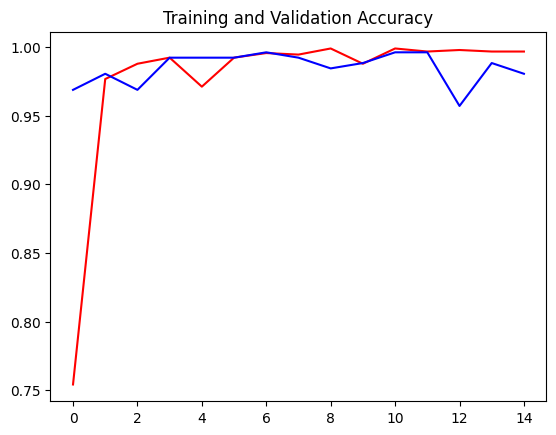

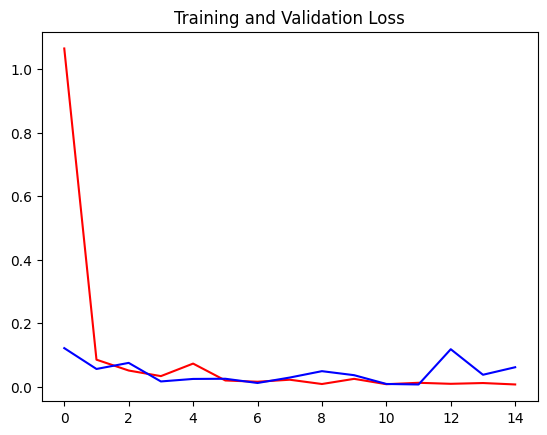

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.show()